#Redes Neuronales Multicapa y Redes Neuronales Convolucionales
Objetivo: Clasificar dígitos escritos a mano con una red neuronal multicapa y una red covolucional

In [ ]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm # Loading bar

# Importar paquetes para evaluación
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Importar paquetes de pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Importar paquetes de  torchvision
from torchvision import datasets
from torchvision import transforms

## Preparación de los datos

#### Descargar el conjunto de datos y visualizar imágenes**
1. Descargar el conjunto de datos.
2. Exploración del conjunto de datos.

**Descargar conjunto de datos**  

Se utiliza el modulo `torchvison.datasets` para descargar el conjunto de datos MNIST.  
Y especificar los siguientes argumentos:
-  `root` Ruta donde se almacena el conjunto de datos.
-  `train` Si *train=True* el conjunto de datos corresponde al conjunto de datos de entrenamiento, *train=False* corresponde a los datos de prueba.
- `download` Descarga el conjunto de datos de internet si no está en la ruta.
- `transform`  Transformaciones en imágenes.  

**Consultar**  
- [Datasets](https://pytorch.org/vision/main/datasets.html)

In [ ]:
# Datos de etrenamiento
mnist_train = datasets.MNIST(root='./data',
                       train=True,
                       download=True,
                       transform = transforms.ToTensor())

In [ ]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
# Datos de prueba
mnist_test = datasets.MNIST(root='./data',
                       train=False,
                       download=True,
                       transform = transforms.ToTensor())

In [ ]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

**Exploración del conjunto de datos**  

In [ ]:
# Diccionario de etiquetas
mnist_train.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

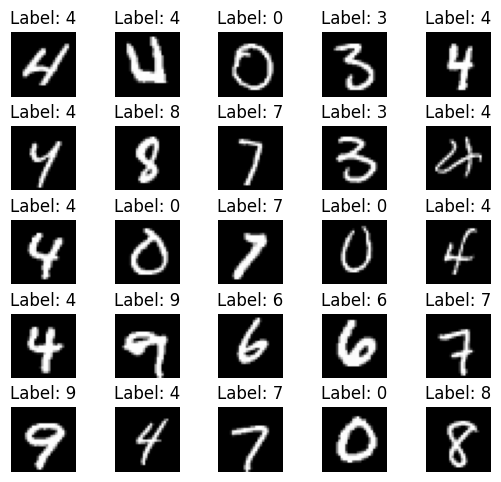

In [ ]:
# Visualizar conjunto de datos
fig = plt.figure(figsize=(5,5))
rows, cols = 5, 5
for i in range(1,rows*cols+1):
    random_idx = random.randint(0, len(mnist_train)) # Seleccionar aleatoriamente una imagen del conjunto de entrenamiento
    img, label = mnist_train[random_idx]
    fig.add_subplot(rows,cols,i)
    fig.tight_layout(pad=0.5)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis("off")

In [ ]:
# Obtener un elemento del conjunto de datos
img, _ = mnist_train[0]
print(f"Tamaño de la imagen: {img.shape}") # Channels First  (NCHW)

Tamaño de la imagen: torch.Size([1, 28, 28])


In [ ]:
# Obtener valores máximos y mínimos
print(f"Valor máximo del tensor: {img.max()}")
print(f"Valor mínimo del tensor: {img.min()}")

Valor máximo del tensor: 1.0
Valor mínimo del tensor: 0.0


In [ ]:
# Número de impagenes por cada clase
targets = mnist_train.targets.numpy()
print(f"Tamaño del vector de etiquetas: {targets.shape}")
elements_targets= np.unique(targets, return_counts=True)
print(f"Etiquetas: {elements_targets[0]}")
print(f"Número de elementos por cada clase: {elements_targets[1]}")

Tamaño del vector de etiquetas: (60000,)
Etiquetas: [0 1 2 3 4 5 6 7 8 9]
Número de elementos por cada clase: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


#### Preparación del Data Loader  
La clase `DataLoader` en PyTorch nos permite cargar e iterar elementos en el conjunto de datos.   
Cada iteración devolverá un lote de imágenes y etiquetas.  
Argumentos:
- `dataset` Conjunto de datos que se va a iterar.
- `batch_size` Cantidad de muestras contenidas en un batch.
- `shuffle` Al especificar *shuffle=True* los datos se revuelven después de iterar sobre todos los batches.  


**Consultar**   
[Datasets y DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataloader = DataLoader(dataset = mnist_train, batch_size = BATCH_SIZE,
                              shuffle = True)

In [ ]:
test_dataloader = DataLoader(dataset = mnist_test, batch_size = BATCH_SIZE,
                              shuffle = True)

In [ ]:
print(f"Número de batches en el train loader: {len(train_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")
print(f"Número de batches en el test loader: {len(test_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")

Número de batches en el train loader: 938 batches de 64 imágenes cada uno
Número de batches en el test loader: 157 batches de 64 imágenes cada uno


In [ ]:
# Verificar que hay dentro del DataLoader
train_batches,label = next(iter(train_dataloader))
print(train_batches.shape)

torch.Size([64, 1, 28, 28])


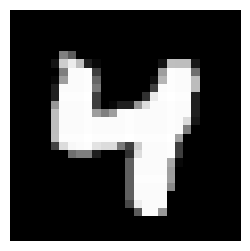

In [ ]:
# Visualizar una imagen en el DataLoader
random_idx = random.randint(0, len(train_batches)-1)
img_batch = train_batches[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze(), cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
# Configuración de CPU o GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## Redes Neuronales Multicapa

#### Definición del modelo


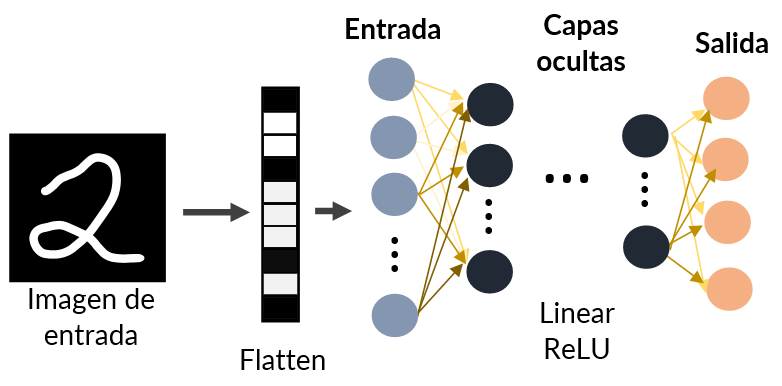

In [ ]:
# Definición de la clase MLP
class MLP(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units*2),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units*2,out_features=output_shape),
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [ ]:
# Configurar el modelo con los parámetros de entrada
mlp= MLP(input_shape=784,hidden_units=16,output_shape=10)
mlp.to(device)

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
# Probar clasificador con entrada dummy
dummy_x = torch.rand([1,1,28,28]).to(device)
print(f"Tamaño del vector de entrada del discriminador: {dummy_x.size()}")
dummy_out = mlp(dummy_x).detach()
print(f"Salida del clasificador: {dummy_out}")
print(f"Tamaño de la salida del clasificador: {dummy_out.shape}")

Tamaño del vector de entrada del discriminador: torch.Size([1, 1, 28, 28])
Salida del clasificador: tensor([[-0.0904,  0.2866,  0.0229, -0.0252,  0.0036,  0.0120,  0.0502,  0.1353,
          0.0604,  0.0351]], device='cuda:0')
Tamaño de la salida del clasificador: torch.Size([1, 10])


In [ ]:
# Definir optimizador
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001)

In [ ]:
#Definir función de costo
cross_entropy = nn.CrossEntropyLoss()

#### Entrenamiento del modelo

In [ ]:
def accuracy(y_true, y_pred):
    '''Función que calcula el accuracy
    Input:
    - y_true: Tensor de etiquetas reales
    - y_pred: Tensor con las predicciones del modelo
    '''
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))
    return acc

In [ ]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer):
    # Cambiar el modelo a entrenamiento
    model.train()
    train_loss = 0
    train_acc = 0
    # Recorrer cada batch del conjunto de entrenamiento
    for batch_idx, (data, target) in enumerate(dataloader):
        # Cambiar datos a GPU
        data = data.to(device)
        target = target.to(device)
        # 1. Pasar los datos por la red (feedforward)
        y_pred_logs = model(data)
        # 2. Calcular la función de costo
        loss = loss_fn(y_pred_logs, target)
        train_loss += loss
        y_pred = torch.softmax(y_pred_logs, dim=1).argmax(dim=1)
        train_acc += accuracy(target, y_pred)
        # 3. Zero gradient buffers
        optimizer.zero_grad()
        # 4. Backpropagate
        loss.backward()
        # 5. Update weights
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc*100.:.4f}%")
    return train_loss, train_acc

In [ ]:
def test(dataloader: DataLoader, model: nn.Module, loss_fn):
    # Cambiar el modelo a evaluación
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for data, target in dataloader:
            # Cambiar datos a GPU
            data = data.to(device)
            target = target.to(device)
            # 1. Pasar los datos por la red (feedforward)
            test_pred_logs = model(data)
            # 2. Calcular la función de costo
            val_loss = loss_fn(test_pred_logs, target)
            test_loss += val_loss
            test_pred = torch.softmax(test_pred_logs, dim=1).argmax(dim=1)
            test_acc += accuracy(target, test_pred)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100.:.4f}%")
    return test_loss, test_acc

In [ ]:
EPOCHS = 25

loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    train_loss, train_acc = train(train_dataloader, mlp, cross_entropy, optimizer)
    test_loss, test_acc = test(test_dataloader, mlp, cross_entropy)
    loss_train.append(train_loss.item())
    loss_test.append(test_loss.item())
    acc_train.append(train_acc)
    acc_test.append(test_acc)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 2.2884 | Train acc: 11.7237%
Test loss: 2.2692 | Test acc: 13.5848%
Epoch: 1
--------
Train loss: 2.2514 | Train acc: 16.7894%
Test loss: 2.2287 | Test acc: 19.2974%
Epoch: 2
--------
Train loss: 2.2047 | Train acc: 20.6390%
Test loss: 2.1720 | Test acc: 22.0541%
Epoch: 3
--------
Train loss: 2.1357 | Train acc: 24.6568%
Test loss: 2.0849 | Test acc: 28.9212%
Epoch: 4
--------
Train loss: 2.0301 | Train acc: 32.9907%
Test loss: 1.9531 | Test acc: 37.4900%
Epoch: 5
--------
Train loss: 1.8718 | Train acc: 42.7672%
Test loss: 1.7600 | Test acc: 47.6612%
Epoch: 6
--------
Train loss: 1.6509 | Train acc: 52.8385%
Test loss: 1.5078 | Test acc: 57.2651%
Epoch: 7
--------
Train loss: 1.3995 | Train acc: 61.0358%
Test loss: 1.2645 | Test acc: 65.6648%
Epoch: 8
--------
Train loss: 1.1838 | Train acc: 67.6922%
Test loss: 1.0712 | Test acc: 71.8750%
Epoch: 9
--------
Train loss: 1.0197 | Train acc: 72.0916%
Test loss: 0.9289 | Test acc: 75.2389%
Epoch: 10
--------
T

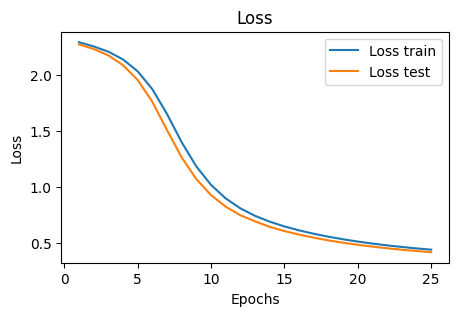

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), loss_train)
plt.plot(np.arange(1,EPOCHS+1), loss_test)
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss train', 'Loss test'])
plt.show()

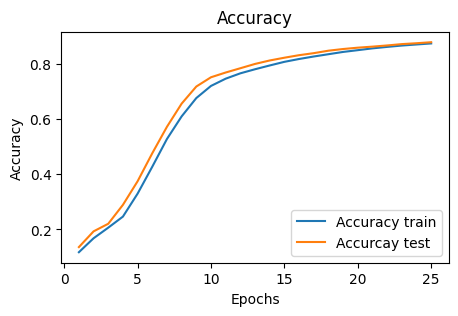

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), acc_train)
plt.plot(np.arange(1,EPOCHS+1), acc_test)
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy train', 'Accurcay test'])
plt.show()

#### Evaluación del modelo

In [ ]:
y_preds = []
y_true = []
mlp.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions ..."):
        X = X.to(device)
        y_pred_logs = mlp(X)
        y_pred = torch.softmax(y_pred_logs, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)

Making predictions ...:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
# Convertir tensores a arreglos numpy
y_true = y_true.numpy()
y_preds = y_preds.numpy()

In [ ]:
# Utilizar matriz de confusión
cf_matrix = confusion_matrix(y_true, y_preds)

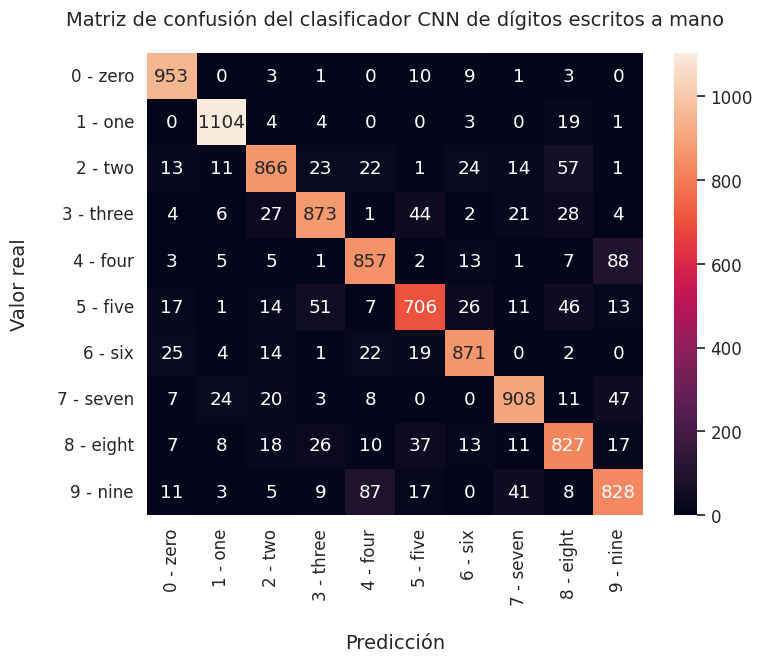

In [ ]:
plt.figure(figsize=(8,6))
# Modificar el tamaño del texto
sns.set(font_scale = 1.1)

# Plot Matriz de confusión con heatmaps
# Parámetros:
# - first param - Matriz de confusión en un formato array
# - annot = True: Muestra los números en cada celda del heatmap
# - fmt = 'd': Muestra los números como enteros.
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', )

# set x-axis label and ticks.
ax.set_xlabel("Predicción", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(mnist_test.classes, rotation=90)

# set y-axis label and ticks
ax.set_ylabel("Valor real", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(mnist_test.classes, rotation=0)

# set plot title
ax.set_title("Matriz de confusión del clasificador CNN de dígitos escritos a mano", fontsize=14, pad=20)
plt.show()

In [ ]:
# Reporte de clasificación
print(classification_report(y_true, y_preds, target_names=mnist_test.classes))

              precision    recall  f1-score   support

    0 - zero       0.92      0.97      0.94       980
     1 - one       0.95      0.97      0.96      1135
     2 - two       0.89      0.84      0.86      1032
   3 - three       0.88      0.86      0.87      1010
    4 - four       0.85      0.87      0.86       982
    5 - five       0.84      0.79      0.82       892
     6 - six       0.91      0.91      0.91       958
   7 - seven       0.90      0.88      0.89      1028
   8 - eight       0.82      0.85      0.83       974
    9 - nine       0.83      0.82      0.82      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Redes Neuronales Convolucionales

#### Definición del modelo

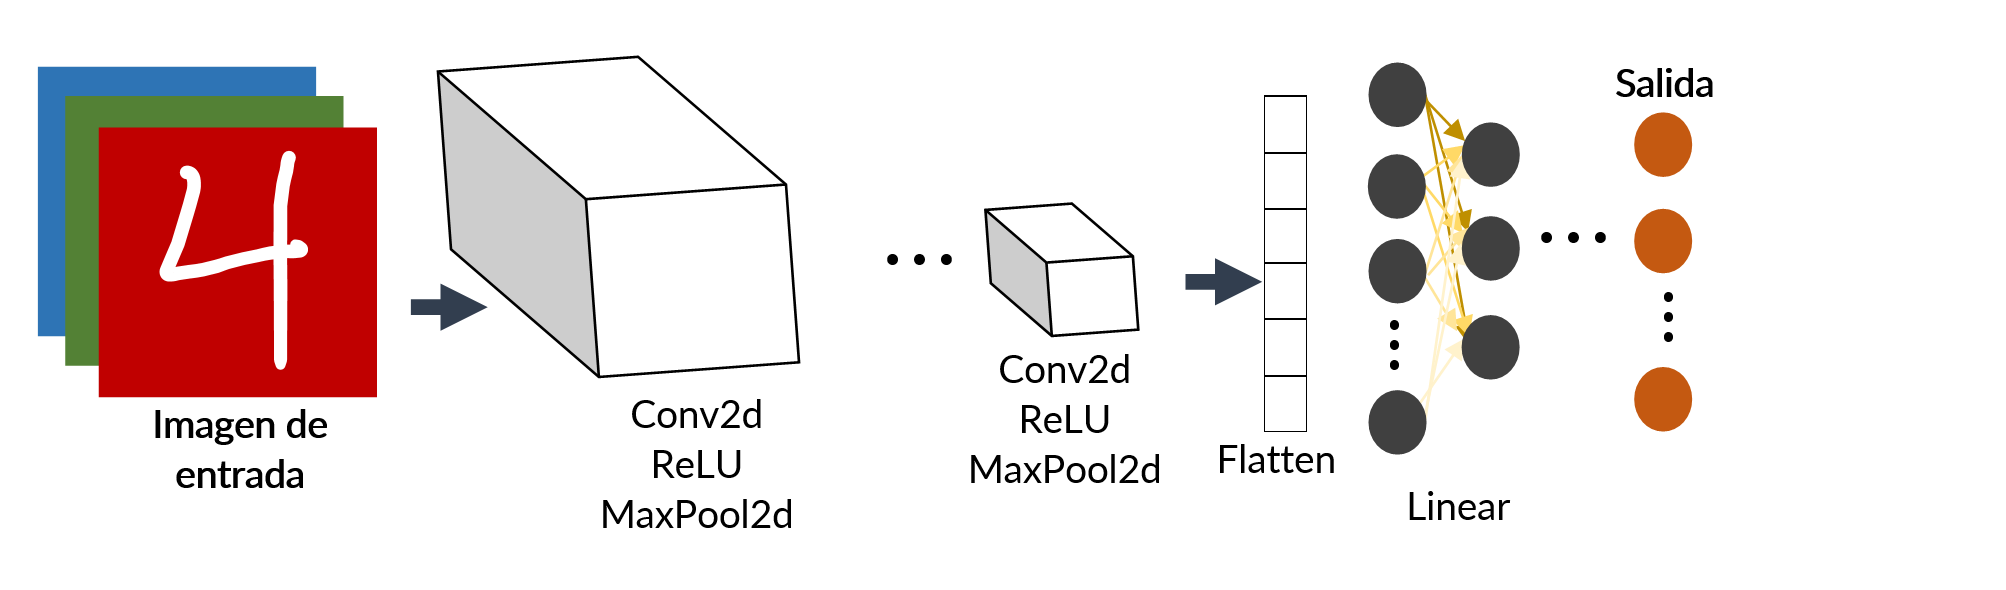

In [ ]:
# Definición de la clase CNN
class CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, # Canales de entrada
                      out_channels=hidden_units, # Canales de salida
                      kernel_size=3, # Tamaño del kernel
                      stride=1, # Tamaño del stride
                      padding=1),# Tamaño del padding
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # Tamaño de la ventana para to,ar el máximo valor
                         stride=2), # El valor por default del stride es el mismo que el del kernel_size

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3136, out_features=100),
            nn.Dropout(0.2),
            nn.Linear(in_features=100, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [ ]:
# Configurar el modelo con los parámetros de entrada
cnn= CNN(input_shape=1,hidden_units=32,output_shape=10)
cnn.to(device)

CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=100, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [ ]:
# Probar clasificador con entrada dummy
dummy_x = torch.rand([1,1,28,28]).to(device)
print(f"Tamaño del vector de entrada del discriminador: {dummy_x.size()}")
dummy_out = mlp(dummy_x).detach()
print(f"Salida del clasificador: {dummy_out}")
print(f"Tamaño de la salida del clasificador: {dummy_out.shape}")

Tamaño del vector de entrada del discriminador: torch.Size([1, 1, 28, 28])
Salida del clasificador: tensor([[ 4.1640, -7.6542,  3.4580,  1.4352, -2.1774,  4.2456,  1.0539, -3.6499,
          3.8189, -1.0927]], device='cuda:0')
Tamaño de la salida del clasificador: torch.Size([1, 10])


In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [ ]:
#Definir función de costo
cross_entropy = nn.CrossEntropyLoss()

In [ ]:
def accuracy(y_true, y_pred):
    '''Función que calcula el accuracy
    Input:
    - y_true: Tensor de etiquetas reales
    - y_pred: Tensor con las predicciones del modelo
    '''
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))
    return acc

In [ ]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer):
    # Cambiar el modelo a entrenamiento
    model.train()
    train_loss = 0
    train_acc = 0
    # Recorrer cada batch del conjunto de entrenamiento
    for batch_idx, (data, target) in enumerate(dataloader):
        # Cambiar datos a GPU
        data = data.to(device)
        target = target.to(device)
        # 1. Pasar los datos por la red (feedforward)
        y_pred_logs = model(data)
        # 2. Calcular la función de costo
        loss = loss_fn(y_pred_logs, target)
        train_loss += loss
        y_pred = torch.softmax(y_pred_logs, dim=1).argmax(dim=1)
        train_acc += accuracy(target, y_pred)
        # 3. Zero gradient buffers
        optimizer.zero_grad()
        # 4. Backpropagate
        loss.backward()
        # 5. Update weights
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc*100.:.4f}%")
    return train_loss, train_acc

In [ ]:
def test(dataloader: DataLoader, model: nn.Module, loss_fn):
    # Cambiar el modelo a evaluación
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)
            test_pred_logs = model(data)
            val_loss = loss_fn(test_pred_logs, target)
            test_loss += val_loss
            test_pred = torch.softmax(test_pred_logs, dim=1).argmax(dim=1)
            test_acc += accuracy(target, test_pred)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100.:.4f}%")
    return test_loss, test_acc

In [ ]:
EPOCHS = 5

loss_train, acc_train = [], []
loss_test, acc_test = [], []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    train_loss, train_acc = train(train_dataloader, cnn, cross_entropy, optimizer)
    test_loss, test_acc = test(test_dataloader, cnn, cross_entropy)
    loss_train.append(train_loss.item())
    loss_test.append(test_loss.item())
    acc_train.append(train_acc)
    acc_test.append(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.1456 | Train acc: 95.7123%
Test loss: 0.0617 | Test acc: 97.8901%
Epoch: 1
--------
Train loss: 0.0603 | Train acc: 98.1443%
Test loss: 0.0480 | Test acc: 98.4574%
Epoch: 2
--------
Train loss: 0.0468 | Train acc: 98.5524%
Test loss: 0.0393 | Test acc: 98.6963%
Epoch: 3
--------
Train loss: 0.0379 | Train acc: 98.8190%
Test loss: 0.0403 | Test acc: 98.7062%
Epoch: 4
--------
Train loss: 0.0324 | Train acc: 98.9506%
Test loss: 0.0343 | Test acc: 98.9451%


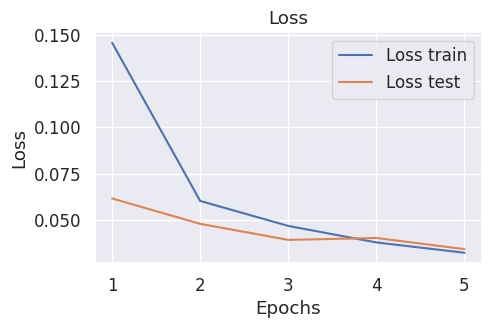

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), loss_train)
plt.plot(np.arange(1,EPOCHS+1), loss_test)
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss train', 'Loss test'])
plt.show()

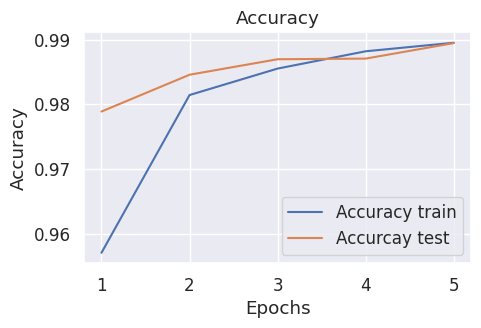

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), acc_train)
plt.plot(np.arange(1,EPOCHS+1), acc_test)
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy train', 'Accurcay test'])
plt.show()

In [ ]:
y_preds = []
y_true = []
cnn.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions ..."):
        X = X.to(device)
        y_pred_logs = cnn(X)
        y_pred = torch.softmax(y_pred_logs, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)

Making predictions ...:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
# Convertir tensores a arreglos numpy
y_true = y_true.numpy()
y_preds = y_preds.numpy()

In [ ]:
# Utilizar matriz de confusión
cf_matrix = confusion_matrix(y_true, y_preds)

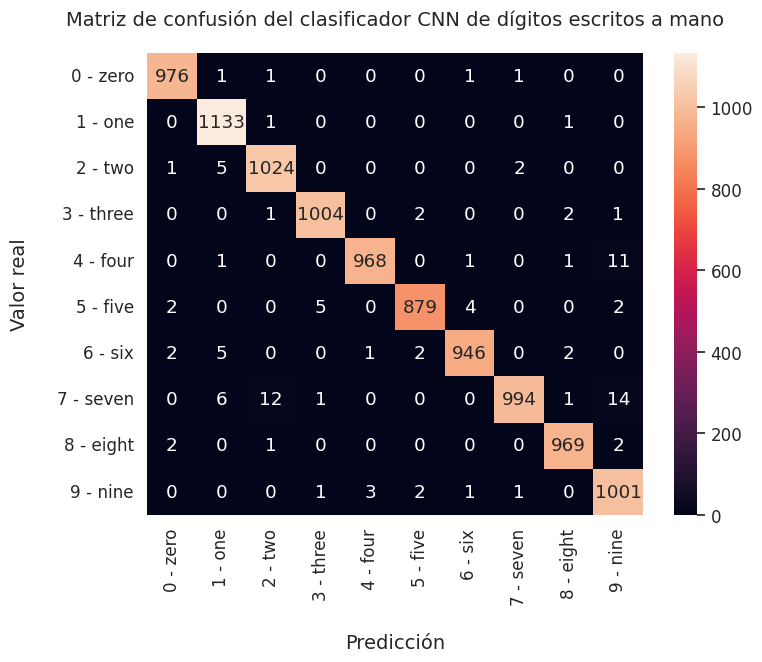

In [ ]:
plt.figure(figsize=(8,6))
# Modificar el tamaño del texto
sns.set(font_scale = 1.1)

# Plot Matriz de confusión con heatmaps
# Parámetros:
# - first param - Matriz de confusión en un formato array
# - annot = True: Muestra los números en cada celda del heatmap
# - fmt = 'd': Muestra los números como enteros.
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', )

# set x-axis label and ticks.
ax.set_xlabel("Predicción", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(mnist_test.classes, rotation=90)

# set y-axis label and ticks
ax.set_ylabel("Valor real", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(mnist_test.classes, rotation=0)

# set plot title
ax.set_title("Matriz de confusión del clasificador CNN de dígitos escritos a mano", fontsize=14, pad=20)
plt.show()

In [ ]:
# Reporte de clasificación
print(classification_report(y_true, y_preds, target_names=mnist_test.classes))

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99       980
     1 - one       0.98      1.00      0.99      1135
     2 - two       0.98      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       1.00      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       1.00      0.97      0.98      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

